# 窗口函数 #

- 基本语法：
    ```sql
    <窗口函数> over (partition by <用于分组的列名>
                order by <用于排序的列名>)
    ```
    - 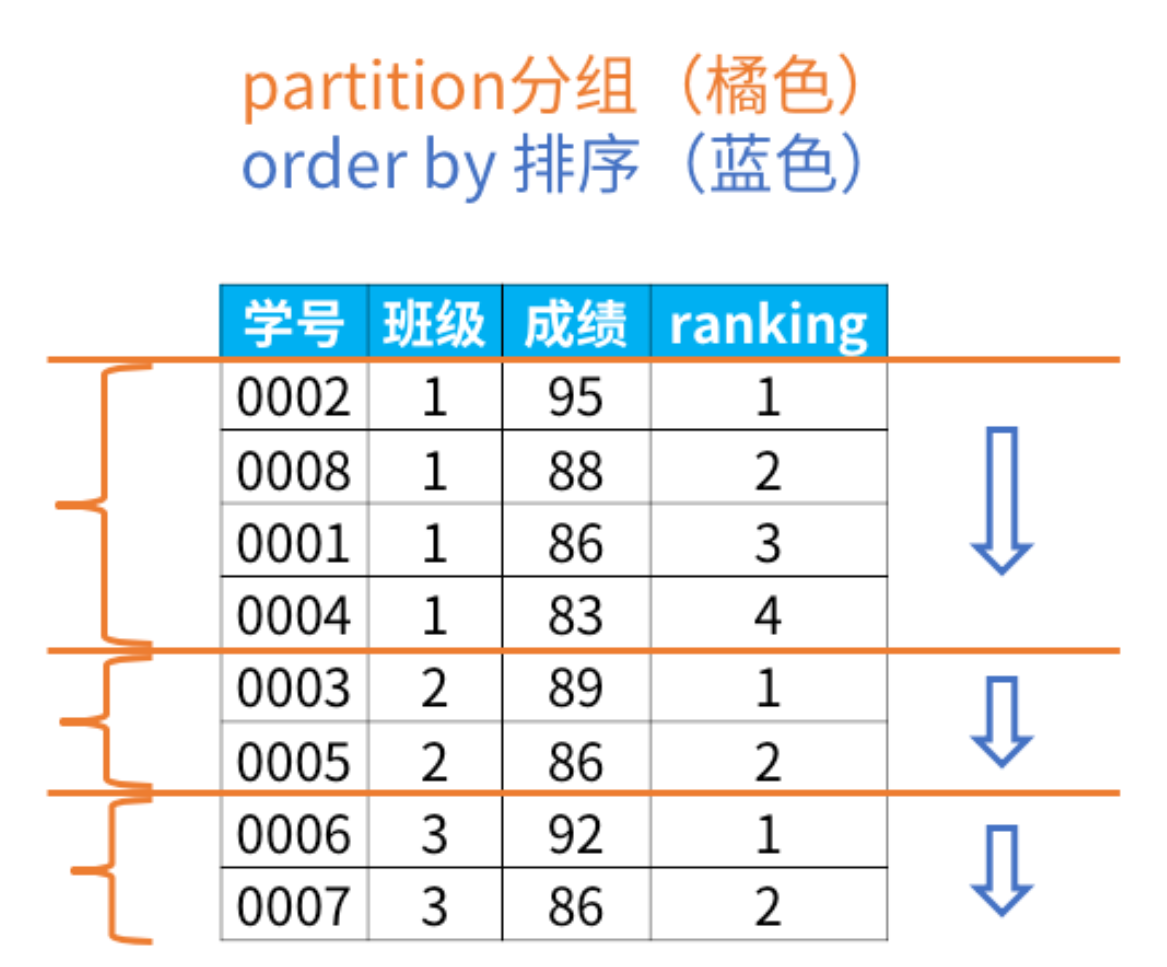

- 用处：
    - 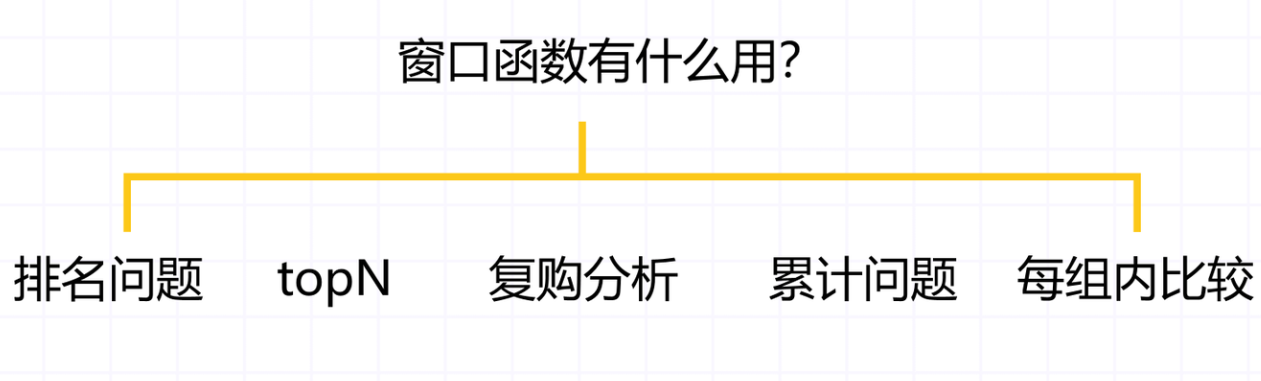

- 常见窗口函数：
    - `rank`函数：这个例子中是5位，5位，5位，8位，也就是如果有并列名次的行，会占用下一名次的位置。比如正常排名是1，2，3，4，但是现在前3名是并列的名次，结果是：1，1，1，4。
    - `dense_rank`函数：这个例子中是5位，5位，5位，6位，也就是如果有并列名次的行，不占用下一名次的位置。比如正常排名是1，2，3，4，但是现在前3名是并列的名次，结果是：1，1，1，2。
    - `row_number`函数：这个例子中是5位，6位，7位，8位，也就是不考虑并列名次的情况。比如前3名是并列的名次，排名是正常的1，2，3，4。
    - 聚合函数（如`sum`,`avg`等）：针对自身记录、以及自身记录之上的所有数据进行计算。
    - `Lag`/`Lead`(col,n,DEFAULT)用于统计窗口内当前行往前或者往后第n行值
        - 第一个参数为列名
        - 第二个参数为往后/前第n行(可选，默认为1)
        - 第三个参数为默认值(当往上第n行为NULL时候，取默认值，如不指定，则为NULL)

In [ ]:
# leetcode 178：分数排名
# Write your MySQL query statement below
SELECT score, DENSE_RANK() OVER (ORDER BY score DESC) AS 'rank'
FROM Scores
ORDER BY score DESC, 'rank' ASC;

# 连续登录 #

解题步骤：
1. 去重
2. 窗口函数排序（PARTITION BY <标识符，如id> ORDER BY <连续增长的值，如date>）+ 算差值（连续时该数相同）
3. 分组统计（GROUP BY <标识符，如id>，<固定差值，如diff>）
4. 找DISTINCT的最大值

In [ ]:
# leetcode 180: 连续数字
# Write your MySQL query statement below
WITH sub AS(
    SELECT id, num, ROW_NUMBER() OVER (PARTITION BY num ORDER BY id) AS consecutive,
    id -  ROW_NUMBER() OVER (PARTITION BY num ORDER BY id) AS diff -- fixed value
    FROM Logs
    ORDER BY id
),
sub2 AS (
    SELECT num, diff, count(*) AS count_con  
    FROM sub
    GROUP BY num, diff -- group by the concecutive item and the fixed diff
)

SELECT DISTINCT(num) AS ConsecutiveNums
FROM sub2
WHERE count_con >= 3;

In [ ]:
# leetcode 550: 第一次登陆后连续两天登录
# Write your MySQL query statement below
WITH sub AS (
    SELECT player_id,
            event_date, 
            -- DATEDIFF(event_date, LAG(event_date, 1) OVER (PARTITION BY player_id ORDER BY event_date ASC)) AS diff_day
            DATEDIFF(event_date, MIN(event_date) OVER (PARTITION BY player_id ORDER BY event_date ASC)) AS diff_day
    FROM Activity
)

SELECT     
    ROUND((SELECT COUNT(DISTINCT player_id)
    FROM sub
    WHERE diff_day=1)/COUNT(DISTINCT player_id),2) AS fraction
FROM sub

# 留存问题 #

# 峰值 #

1. sub统计了每个城市每小时的电话数量，使用了HOUR函数从call_time提取小时并进行分组统计。
2. COUNT(1)用于计数每个城市每小时的通话次数。
3. sub2使用RANK()窗口函数，根据通话数量降序排列，为每个城市内的小时记录分配一个排名。
4. 从sub2中选择城市、小时和通话次数，但只有排名为1的记录，即每个城市通话量最多的小时。
5. 结果按小时降序和城市降序排序。

In [ ]:
# leetcode 2984
WITH sub AS
(
    SELECT
        city,
        HOUR(call_time) AS h,
        COUNT(1) AS cnt
    FROM Calls
    GROUP BY 1, 2
), sub2 AS 
(
    SELECT *,
            RANK() OVER (PARTITION BY city ORDER BY cnt DESC) AS rk
    FROM sub
)

SELECT city, h AS peak_calling_hour, cnt AS number_of_calls
FROM sub2
WHERE rk = 1
ORDER BY 2 DESC, 1 DESC;

# 行转列 #

# 比较效率 #

分析SQL查询的效率通常涉及以下几个步骤：
- 查看执行计划：大多数数据库管理系统（如SQL Server, PostgreSQL, Oracle等）提供了查看查询执行计划的工具。执行计划会显示查询的详细执行过程，包括哪些- 索引被使用，每个操作的成本评估，以及数据检索和处理的顺序。
- 优化索引使用：确保查询中涉及的表具有适当的索引以加速数据访问。执行计划可以帮助识别缺少索引的情况。
- 减少数据访问：通过优化查询逻辑，尽可能减少访问的数据量，例如使用适当的WHERE子句条件或限制返回的数据行数。
- 使用分析函数和适当的聚合策略：例如，避免在必要的查询中使用子查询，可以改用JOIN或窗口函数来提高效率。

1. 给定table(class no,student_no,score)，找每个班级最高分的学生有哪些方法，并比较效率

In [ ]:
# 方法1：分组筛最高分查询 - 简单直观，但可能在大数据集上效率不高

SELECT class_no, student_no, score
FROM scores
WHERE (class_no, score) IN (
    SELECT class_no, MAX(score)
    FROM scores
    GROUP BY class_no
)

In [ ]:
# 方法2：使用窗口函数RANK()或ROW_NUMBER()配合PARTITION BY来为每个班级的学生成绩排名，然后筛选排名最高的。 - 比子查询更高效

WITH RankedScores AS (
    SELECT class_no, student_no, score,
           RANK() OVER (PARTITION BY class_no ORDER BY score DESC) as rank
    FROM scores
)
SELECT class_no, student_no, score
FROM RankedScores
WHERE rank = 1
